In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

%load_ext autoreload  
%autoreload 2


from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndimage
from scipy.interpolate import griddata  # got it to work!
from scipy.interpolate import interp1d
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

import numpy.polynomial.polynomial as poly

from scipy.special import sph_harm  # spherical harmonics
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.sph_harm.html

# some color maps
#colormap='gist_ncar'
#colormap='gist_stern'
#colormap='terrain'
#colormap='prism'
#colormap='rainbow'
#https://matplotlib.org/examples/color/colormaps_reference.html


This routine makes the following figures that were used in the paper on Bennu
vr2ave_eq_long2.png
vr2ave_15_long2.png
vr2ave_65_long2.png
max_eq_s.png
max_15_s.png
max_65_s.png


In [2]:
angfac = 180.0/np.pi # for converting radians to degrees
twopi = np.pi*2.0

# return filename
def getfilename(fileroot,npi):  # file format fileroot_%d.txt
    junk = '.txt'
    zeros = ''
    if (npi<10):
        zeros = zeros+ '0'
    if (npi<100):
        zeros = zeros+ '0'
    if (npi<1000):
        zeros = zeros+ '0'
    if (npi<10000):
        zeros = zeros+ '0'
    filename = "%s_%s%d%s"%(fileroot,zeros,npi,junk)
    return filename

# read in a surface file format fileroot_%d.txt
# A surface file only contains nodes near the surface
# if npi==-1 then readin the special file fileroot_nosprings.txt instead
def readsurffile(fileroot,npi):
    if (npi<0):
        filename = fileroot + "_nosprings.txt"  
        # this file should have gravity only in ax,ay,az
    else:
        filename=getfilename(fileroot,npi)
    #print(filename)
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm =\
           np.loadtxt(filename, skiprows=1, unpack='true')
    rad = np.sqrt(x*x + y*y + z*z)
    latarr = np.arcsin(z/rad)  # range [-pi/2,pi/2]
    lonarr_neg = np.arctan2(y,x)   # range [-pi,pi]
    lonarr = (lonarr_neg + twopi)%twopi
    vr = (vx*x + vy*y + vz*z)/rad  # radial component of velocity
    ar = (ax*x + ay*y + az*z)/rad  # radial component of acceleration
    return tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar


In [3]:
# all grids the same, set their points here
gridn=50  # for grids, number of lattitude grid points 
maxlon=2.5*np.pi  # for griding, allowing longitude past 360 degrees
lonfac = 1.8   # so can have more longnitude grid points

# lats_i, lons_i are meshgrids
def forgrid():
    lats = np.linspace(-np.pi/2, np.pi/2, gridn) # latitude grid
    lons = np.linspace(0.0, maxlon, lonfac*gridn)  #longitude grid
    lons_i, lats_i = np.meshgrid(lons, lats)  # rectangular grid
    return lats,lons,lats_i,lons_i  # return grid information

# do interpolation,  lonarr,latarr,show_arr are the points
# grid is given by lons_i,lats_i (mesh grids arrays)
# this how works for lon > 2pi 
# the points to be interpolated are in show_arr
def gridit_interp(lonarr,latarr,show_arr,lons_i,lats_i):
    latarr2 = np.append(latarr,latarr)
    lonarr2 = np.append(lonarr,lonarr+2.0*np.pi)
    show_arr2 = np.append(show_arr,show_arr)
    zi = griddata((lonarr2,latarr2),show_arr2,(lons_i,lats_i), method='linear')
    zin = griddata((lonarr2,latarr2),show_arr2,(lons_i,lats_i), method='nearest')
    # interpolate the data. doing it twice so can cover more than 2pi in longitude
    kk = np.where(np.isnan(zi))
    zi[kk] = zin[kk]  
    return zi
# interpolation does not smooth or average over noisy data, I think only takes nearest
# so is very noisy, however we don't have enough points to do better than this!

# trying to average where there are many points
# I tried this and found that we are not actually oversampled much
# interpolation is in fact the correct method for us right now!
# we don't use this routine
def gridit_average(lonarr,latarr,show_arr,lons,lats,lons_i,lats_i):
    zi = gridit_interp(lonarr,latarr,show_arr,lons_i,lats_i)
    zave = zi*0.0
    nlo = len(lons_i)
    nla = len(lats_i)
    for i in range(nlo-1): #longitudes
        lonmin = lons[i]
        lonmax = lons[i+1]
        for j in range(nla-1):
            latmin = lats[j]
            latmax = lats[j+1]
            good = (lonarr>lonmin)&(lonarr<lonmax)&(latarr>latmin)&(latarr<latmax)
            good2 = ((lonarr+2*np.pi>lonmin)&(lonarr+2*np.pi<lonmax)&(latarr>latmin)&(latarr<latmax))
            kk = np.where(good|good2)
            val = np.mean(show_arr[kk])
            zave[j,i] = val
    return zave

In [4]:
# return <vr^2> computed within range npi, npj, as an array for all surf particles
# returns array (each surface particle) and latarr,lonarr
# a new parameter decayrate lets you decay amplitude of vr if you want to
def avevr2(fileroot,npi,npj,decayrate):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,npi)
    vr2sum = 0*vr
    t0 = tt[0]
    for i in range(npi,npj):
        # read in surface mass nodes from file
        tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,i)
        tfac = np.exp(-(tt[0]-t0)*decayrate)  # decay
        vr2sum = vr2sum + vr*vr*tfac
    vr2sum = vr2sum/float(npj-npi)
    #print('time of last file ', tt[0])
    return latarr,lonarr,vr2sum  


# return maximum positive vr computed within file range npi, npj, computed from all surface particles
# returns array (each surface particle) and a latarr,lonarr
# a new parameter decayrate lets you decay things if you want to
def maxvrpos(fileroot,npi,npj,decayrate):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,npi)
    mysum = 0*vr
    t0 = tt[0]
    for i in range(npi,npj):
        # read in surface mass nodes from file
        tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,i)
        tfac = np.exp(-(tt[0]-t0)*decayrate)
        kk = np.where(vr*tfac > mysum)
        mysum[kk] = vr[kk]
    return latarr,lonarr,mysum  


In [5]:
# just to look at stuff on grids! 
#  data not yet grided in is show_arr
# lonarr, latarr contain longitudes and lattitudes of points
# zmin,zmax are for display range
def plt_on_grid(lonarr,latarr,show_arr,zmin,zmax):
    lats,lons,lats_i,lons_i = forgrid()
    zi=gridit_interp(lonarr,latarr,show_arr,lons_i,lats_i) 
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14) 
    fig=plt.figure(figsize=(8,4))
    plt.pcolormesh(lons_i,lats_i,zi,vmin=zmin, vmax=zmax, cmap='gist_ncar')
    plt.colorbar()
    plt.axis([0, maxlon, -np.pi/2, np.pi/2])
    
    ylabels = [r'$-\pi/2$','0',r'$\pi/2$']
    plt.yticks([-np.pi/2,0,np.pi/2],ylabels)
    xlabels = [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'0', r'$\pi/2$']
    plt.xticks([0.0,np.pi/2,np.pi,3*np.pi/2,2*np.pi, 2.5*np.pi],xlabels)
    
# just to look at stuff on grids! data already grided and given in zi 
# zmin,zmax are for display range
def plt_grided(zi,zmin,zmax):
    lats,lons,lats_i,lons_i = forgrid()
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14) 
    fig=plt.figure(figsize=(8,4))
    plt.pcolormesh(lons_i,lats_i,zi,vmin=zmin, vmax=zmax, cmap='gist_ncar')
    plt.colorbar()
    plt.axis([0, maxlon, -np.pi/2, np.pi/2])
    
    ylabels = [r'$-\pi/2$','0',r'$\pi/2$']
    plt.yticks([-np.pi/2,0,np.pi/2],ylabels)
    xlabels = [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'0', r'$\pi/2$']
    plt.xticks([0.0,np.pi/2,np.pi,3*np.pi/2,2*np.pi, 2.5*np.pi],xlabels)
    

In [49]:
# data not yet grided
# plot 3 sets of gridded data, make grids, only pass pts
def plt3_on_grid(lonarr0,latarr0,show_arr0,
                 lonarr1,latarr1,show_arr1,
                 lonarr2,latarr2,show_arr2,
                 label_arr,zmin,zmax,nsmo,toplabel,ofilename):
    
    colormap='cubehelix'
    lats,lons,lats_i,lons_i = forgrid()
    zi0=gridit_interp(lonarr0,latarr0,show_arr0,lons_i,lats_i)
    zi1=gridit_interp(lonarr1,latarr1,show_arr1,lons_i,lats_i) 
    zi2=gridit_interp(lonarr2,latarr2,show_arr2,lons_i,lats_i) 
    zi0_smo = ndimage.gaussian_filter(zi0, sigma=(nsmo, nsmo), order=0)
    zi1_smo = ndimage.gaussian_filter(zi1, sigma=(nsmo, nsmo), order=0)
    zi2_smo = ndimage.gaussian_filter(zi2, sigma=(nsmo, nsmo), order=0)
    
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14) 
   
    f,axarr =  plt.subplots(3,1, dpi=300, figsize=(6,8), sharex=True,sharey=True)
    plt.subplots_adjust(left=0.16, right=0.79, top=0.95, bottom=0.11, \
        wspace=0.22, hspace=0.0)
    
    ip = 0
    axarr[ip].axis([0, maxlon, -np.pi/2, np.pi/2])
    ylabels = [r'$-\pi/2$',r'$-\pi/4$',r'0',r'$\pi/4$']
    axarr[ip].set_yticks([-np.pi/2,-np.pi/4,0,np.pi/4])
    axarr[ip].set_yticklabels(ylabels)
    xlabels = [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'0', r'$\pi/2$']
    axarr[ip].set_xticks([0.0,np.pi/2,np.pi,3*np.pi/2,2*np.pi,2.5*np.pi])
    axarr[ip].set_xticklabels(xlabels)
    
    axarr[ip].text(np.pi/4,np.pi/2+0.08,toplabel,fontsize=18,color='black')  #toplabel
    xlab = 0.2; ylab=-np.pi/2+0.3  # for label_arr
    ip=0
    im0 = axarr[ip].pcolormesh(lons_i,lats_i,zi0_smo,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
    ip = 1
    im1 = axarr[ip].pcolormesh(lons_i,lats_i,zi1_smo,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
    ip = 2
    im2 = axarr[ip].pcolormesh(lons_i,lats_i,zi2_smo,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
       
    cbaxes0 = f.add_axes([0.81, 0.55, 0.03, 0.35]) 
    cb0= f.colorbar(im0,cax = cbaxes0,format='%.1e')
    cb0.ax.tick_params(labelsize=14)
    
    if (len(ofilename)>3):
        plt.savefig(ofilename)
        
        
# plot 3 sets of gridded data, 
def plt3_grided(zi0,zi1,zi2, 
                label_arr,zmin,zmax,toplabel,ofilename):
    colormap='cubehelix'
    lats,lons,lats_i,lons_i = forgrid()
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14) 
    
    f,axarr =  plt.subplots(3,1, dpi=300, figsize=(6,8), sharex=True,sharey=True)
    plt.subplots_adjust(left=0.16, right=0.82, top=0.97, bottom=0.11, \
        wspace=0.22, hspace=0.0)
    
    ip = 0
    axarr[ip].axis([0, maxlon, -np.pi/2, np.pi/2])
    ylabels = [r'$-\pi/2$',r'$-\pi/4$',r'0',r'$\pi/4$']
    axarr[ip].set_yticks([-np.pi/2,-np.pi/4,0,np.pi/4])
    axarr[ip].set_yticklabels(ylabels)
    xlabels = [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'0', r'$\pi/2$']
    axarr[ip].set_xticks([0.0,np.pi/2,np.pi,3*np.pi/2,2*np.pi,2.5*np.pi])
    axarr[ip].set_xticklabels(xlabels)
    
    xlab = 0.2; ylab=np.pi/2-0.4
    ip=0
    im0 = axarr[ip].pcolormesh(lons_i,lats_i,zi0,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
    ip = 1
    im1 = axarr[ip].pcolormesh(lons_i,lats_i,zi1,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
    ip = 2
    im2 = axarr[ip].pcolormesh(lons_i,lats_i,zi2,vmin=zmin, vmax=zmax, cmap=colormap)
    axarr[ip].text(xlab,ylab,label_arr[ip],fontsize=15,color='white')
       
    cbaxes0 = f.add_axes([0.84, 0.55, 0.03, 0.35]) 
    cb0= f.colorbar(im0,cax = cbaxes0,format='%.1e')
    cb0.ax.tick_params(labelsize=14)
    
    if (len(ofilename)>3):
        plt.savefig(ofilename)
    
    

In [42]:
filerootb1  = "../bennu2/b1_out/b1_surf"
filerootb2  = "../bennu2/b2_out/b2_surf"
filerootb3  = "../bennu2/b3_out/b3_surf"
filerootc1  = "../bennu2/c3_out/c3_surf"
filerootc2  = "../bennu2/c2_out/c2_surf"
filerootc3  = "../bennu2/c6_out/c6_surf"
filerooto1  = "../bennu2/o1_out/o1_surf"
filerooto2  = "../bennu2/o2_out/o2_surf"
filerooto3  = "../bennu2/o3_out/o3_surf"
label_arr = ['Bennu','Cone','Oblate']
toplabel_0 =  r'impact $\lambda_c = 0^\circ$'
toplabel_15 = r'impact $\lambda_c = 15^\circ$'
toplabel_65 = r'impact $\lambda_c = 65^\circ$'
vr_label = r', $\sqrt{\langle v_r^2 \rangle}$'
max_label = r', max $v_r$'

In [47]:
# for plotting <vr2>,  integrating over from 0 to 899 files, is slow to crunch through them all!
# reading stuff in
decayrate=0.0
npi = 0; npj=899
latarrb1,lonarrb1,aveb1=avevr2(filerootb1,npi,npj,decayrate)
latarrb2,lonarrb2,aveb2=avevr2(filerootb2,npi,npj,decayrate)
latarrb3,lonarrb3,aveb3=avevr2(filerootb3,npi,npj,decayrate)

latarrc1,lonarrc1,avec1=avevr2(filerootc1,npi,npj,decayrate)
latarrc2,lonarrc2,avec2=avevr2(filerootc2,npi,npj,decayrate)
latarrc3,lonarrc3,avec3=avevr2(filerootc3,npi,npj,decayrate)

latarro1,lonarro1,aveo1=avevr2(filerooto1,npi,npj,decayrate)
latarro2,lonarro2,aveo2=avevr2(filerooto2,npi,npj,decayrate)
latarro3,lonarro3,aveo3=avevr2(filerooto3,npi,npj,decayrate)


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


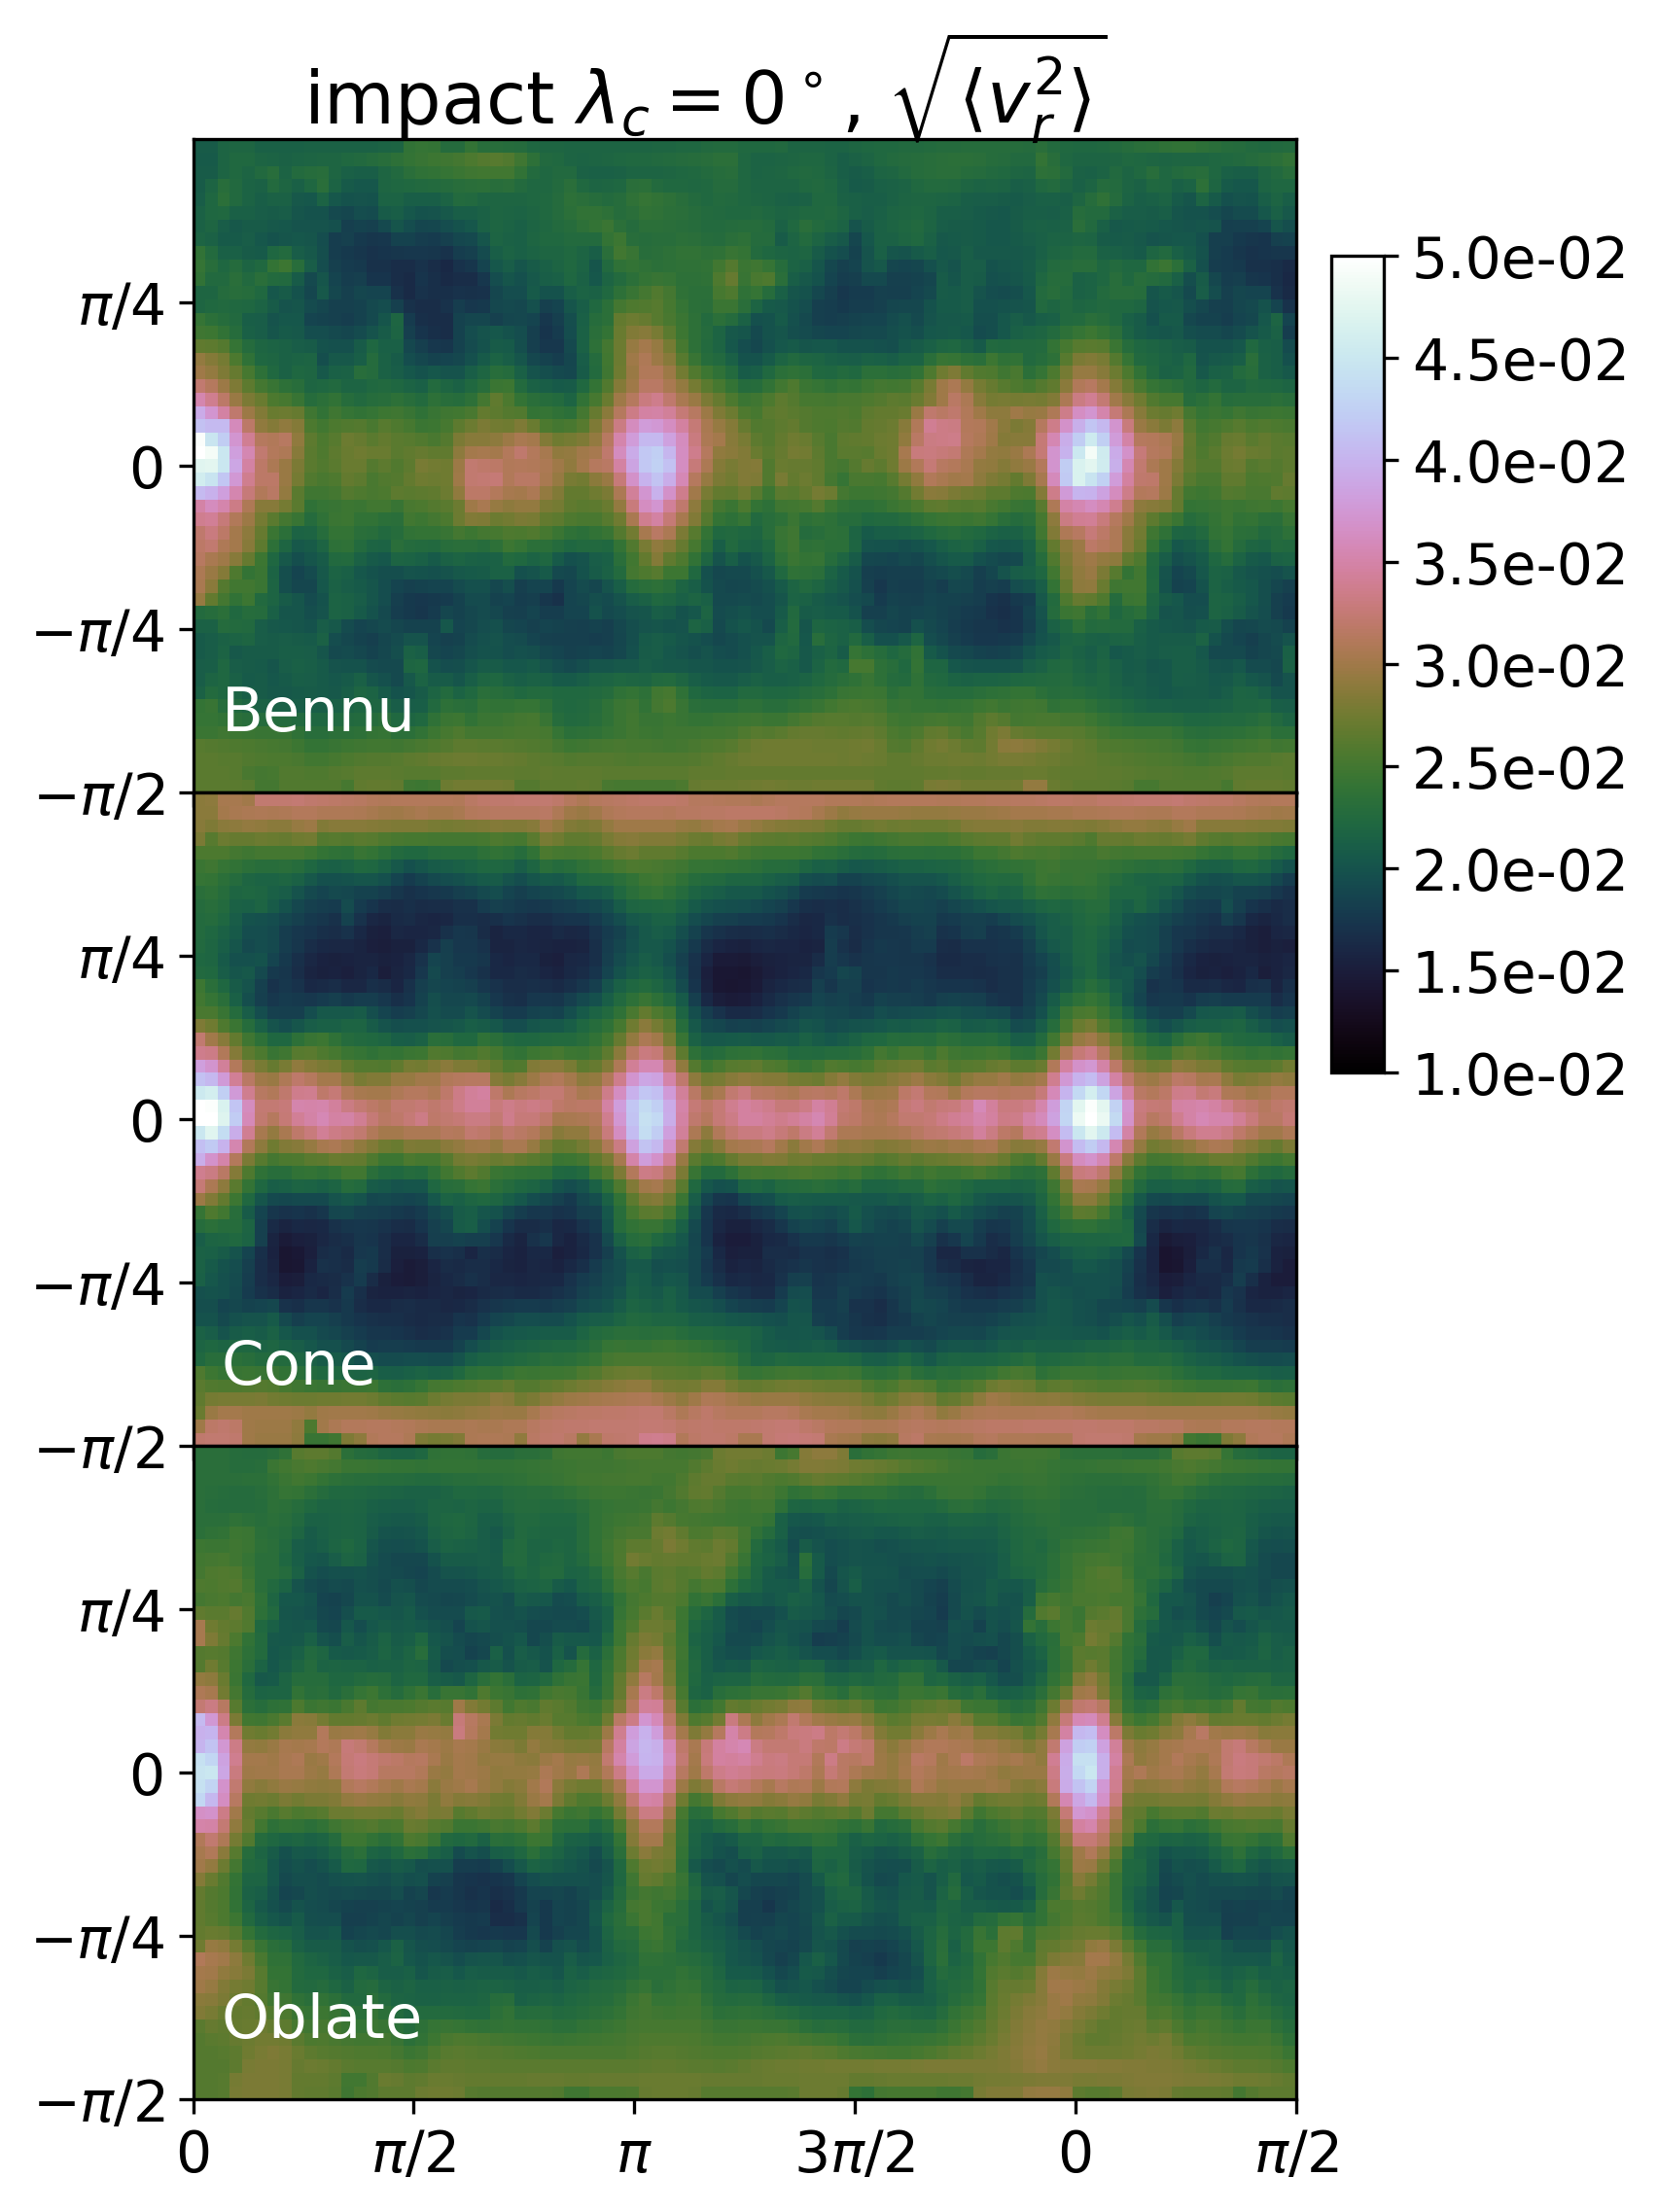

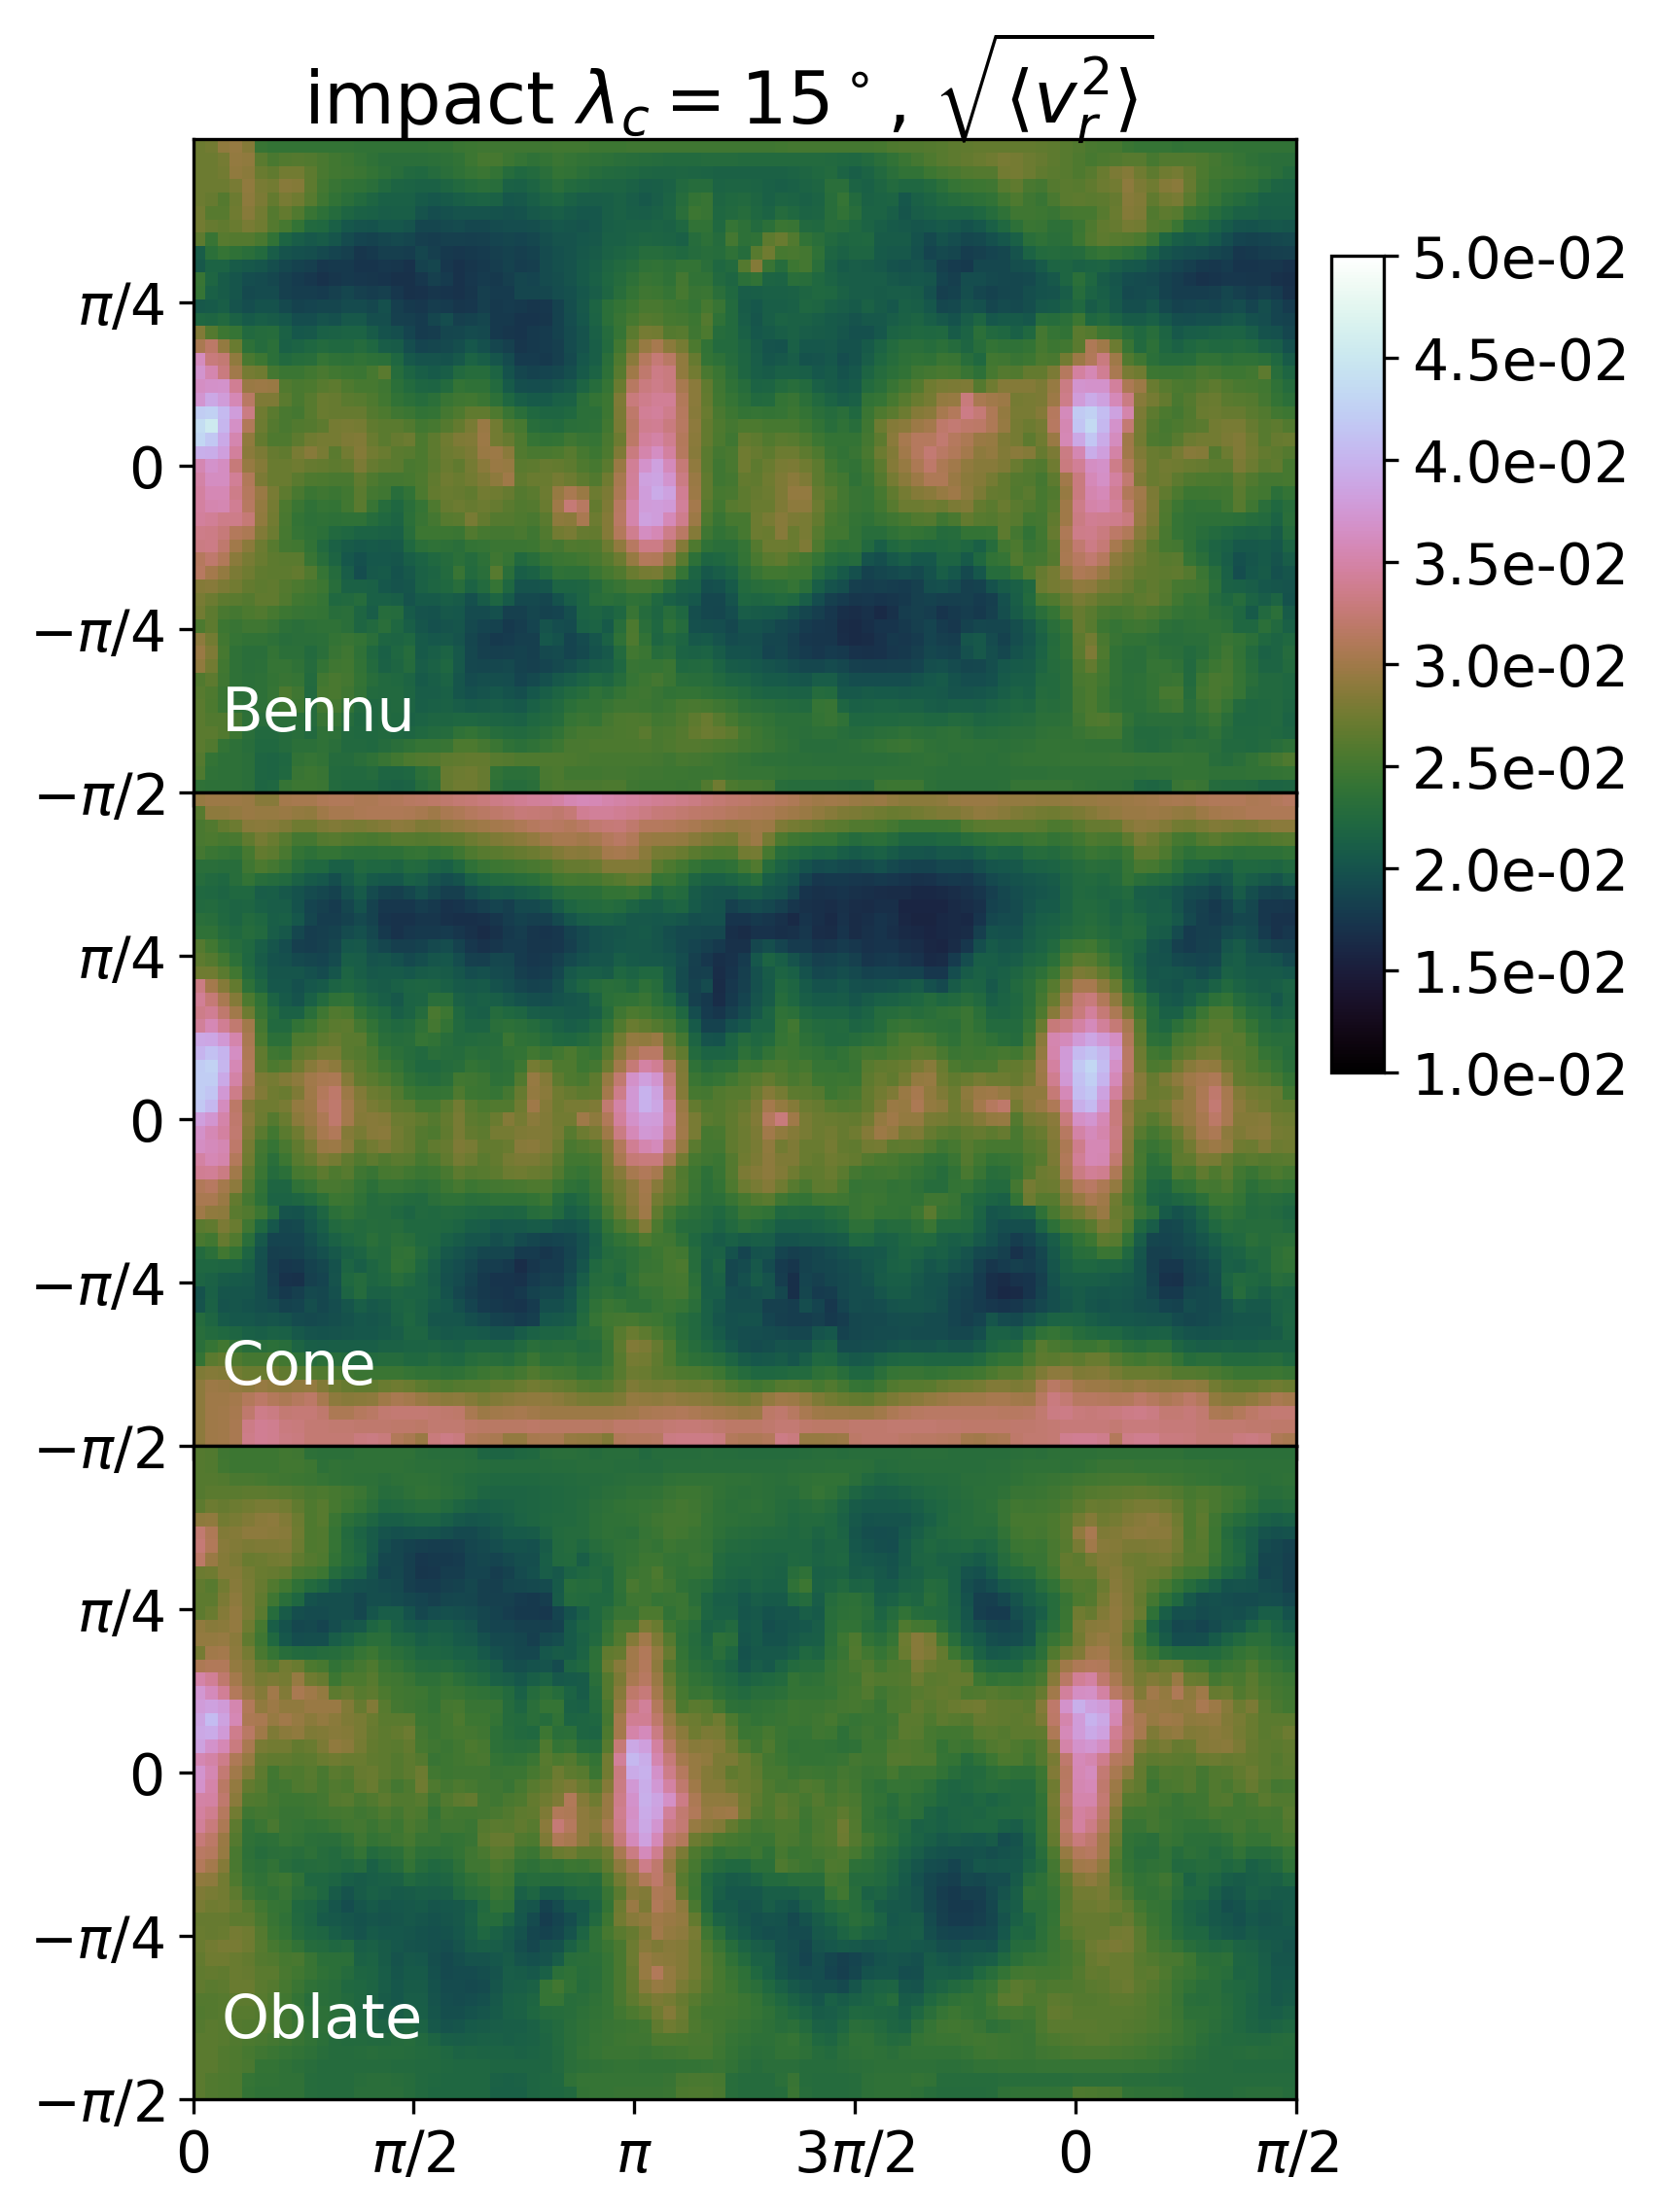

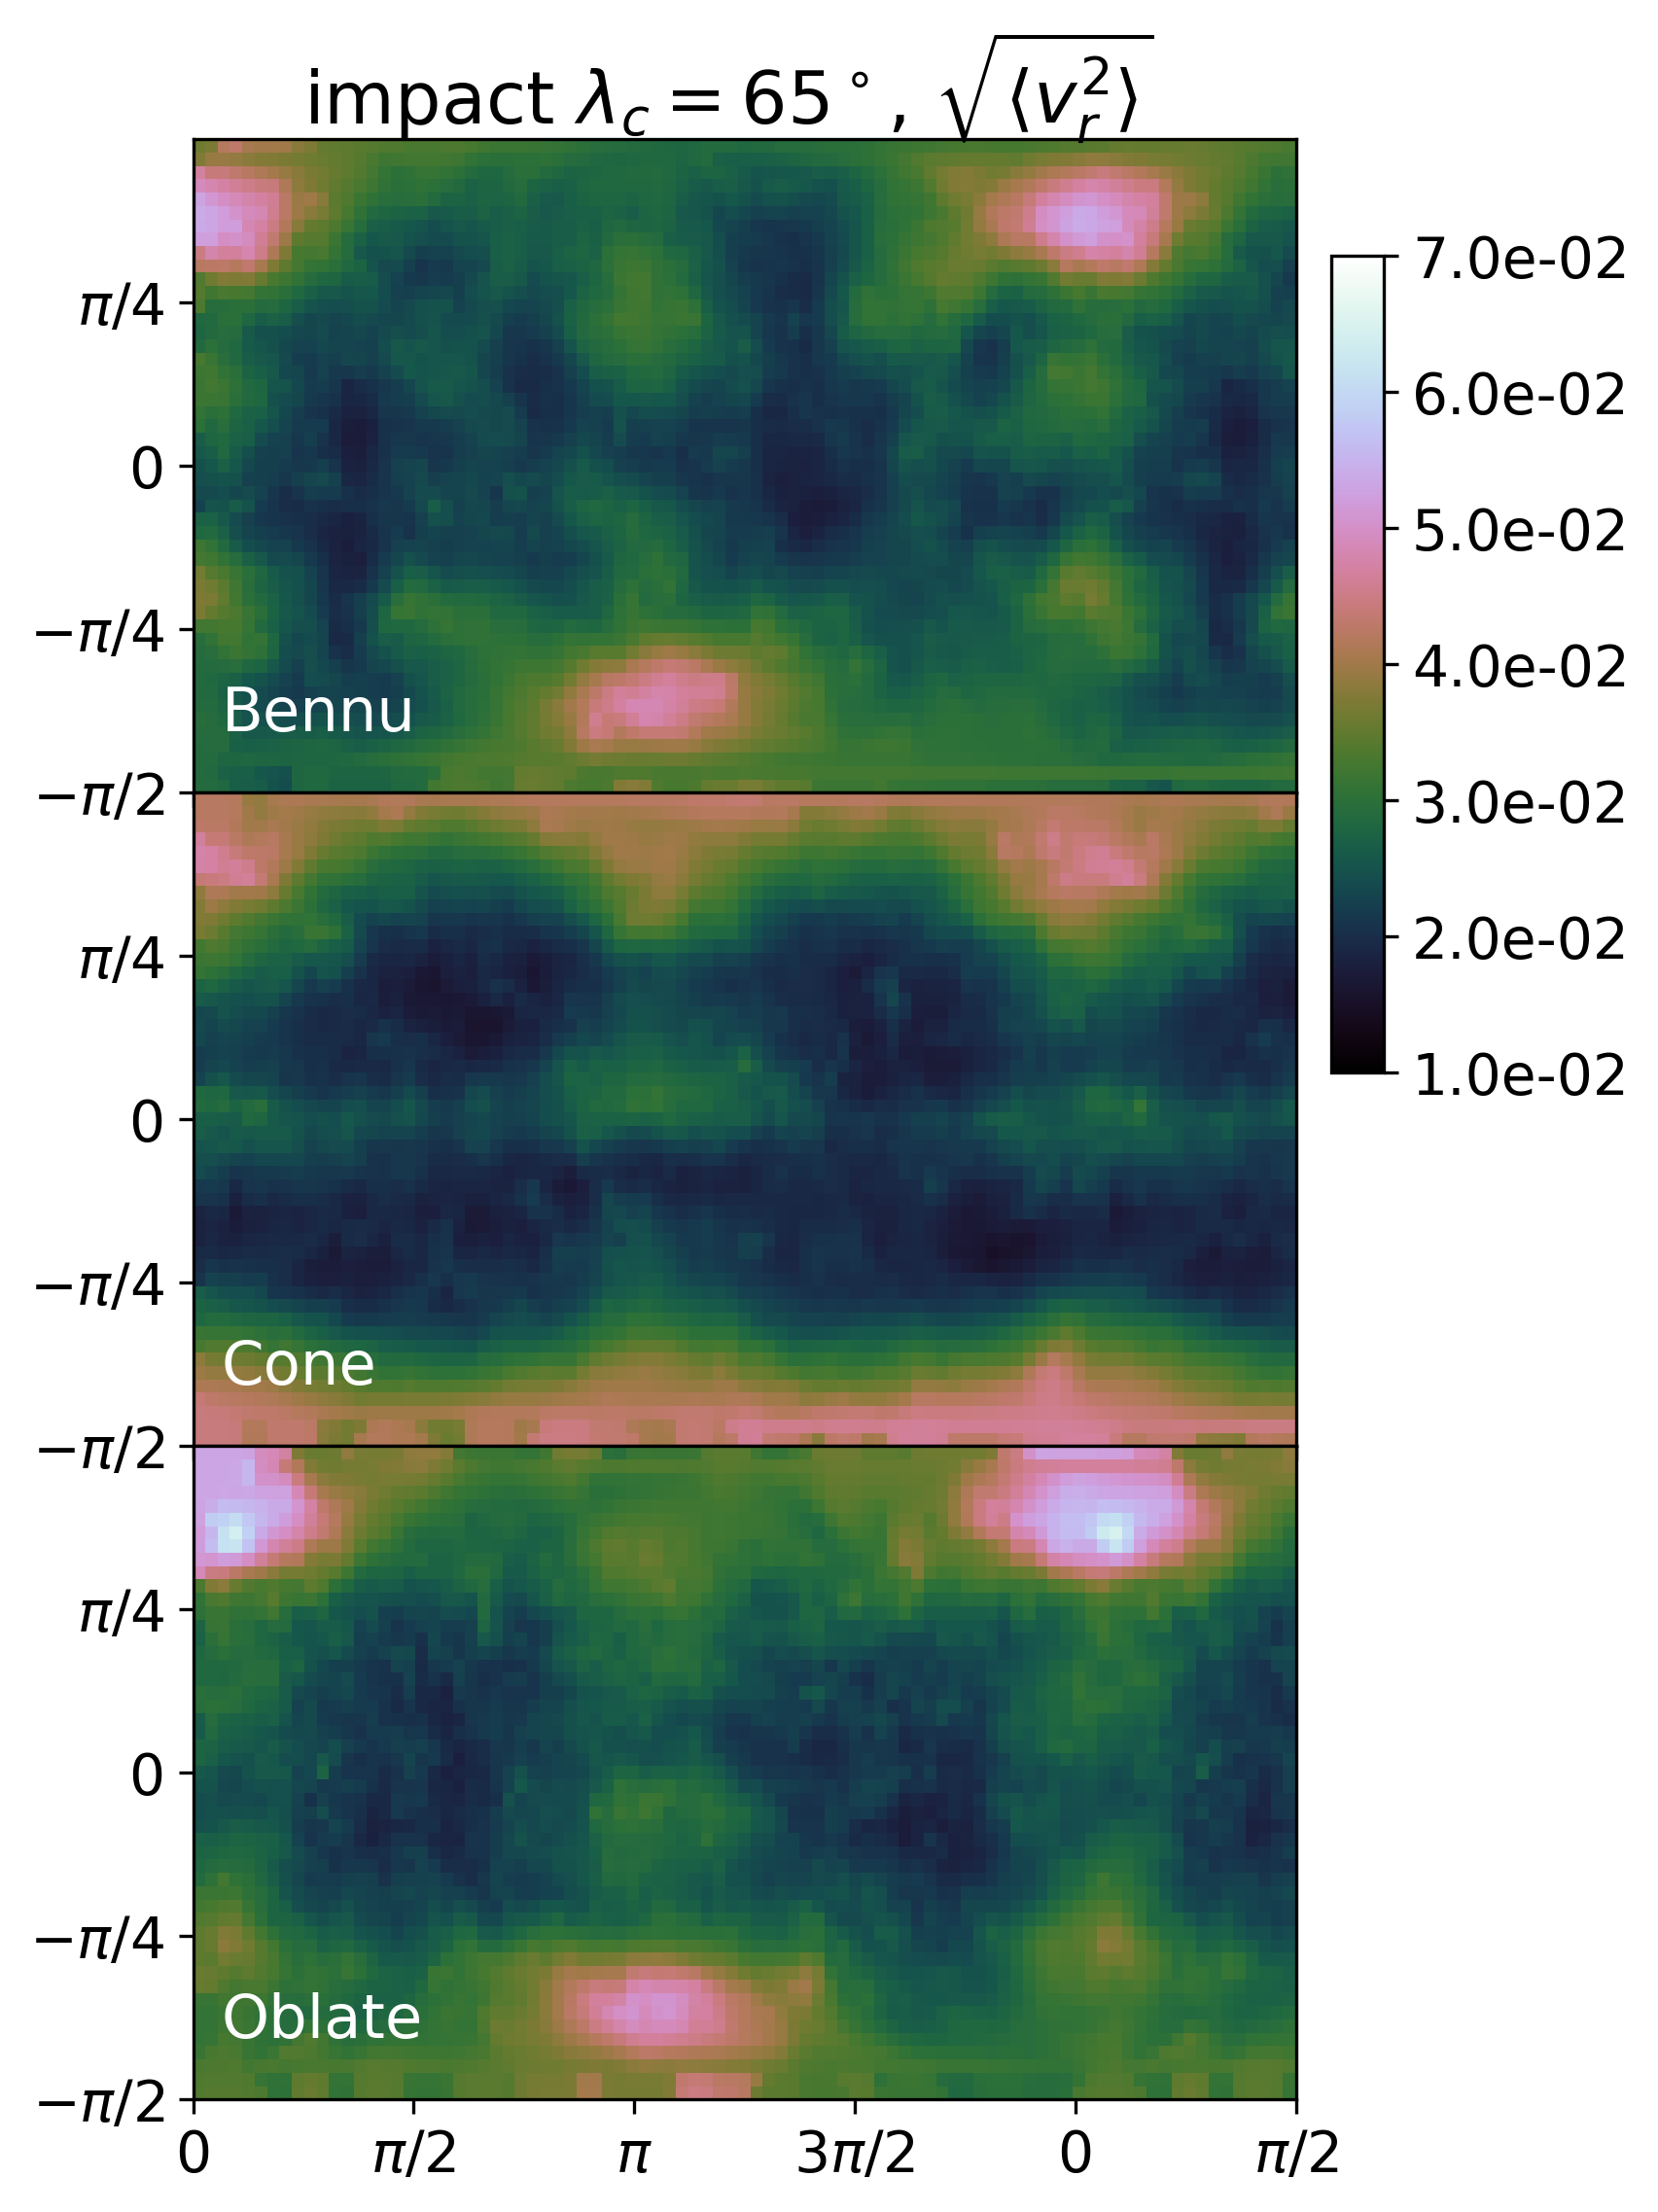

In [50]:
# equatorial impacts longer time images of <vr2>
zmin=1e-2;zmax=5e-2; 
plt3_on_grid(lonarrb1,latarrb1,np.sqrt(aveb1),
             lonarrc1,latarrc1,np.sqrt(avec1),
             lonarro1,latarro1,np.sqrt(aveo1),
             label_arr,zmin,zmax,0.5,toplabel_0+vr_label,"vr2ave_eq_long2.png")
# 15 degree impacts
plt3_on_grid(lonarrb2,latarrb2,np.sqrt(aveb2),
             lonarrc2,latarrc2,np.sqrt(avec2),
             lonarro2,latarro2,np.sqrt(aveo2),
             label_arr,zmin,zmax,0.5,toplabel_15+vr_label,"vr2ave_15_long2.png")
# 65 degree impacts
plt3_on_grid(lonarrb3,latarrb3,np.sqrt(aveb3),
             lonarrc3,latarrc3,np.sqrt(avec3),
             lonarro3,latarro3,np.sqrt(aveo3),
             label_arr,zmin,7e-2,0.5,toplabel_65+vr_label,"vr2ave_65_long2.png")

In [44]:
# plotting max of positive vr, just the first 100 outputs
# read stuff in here
decayrate=0.0e-2  # Rayleigh speed to antipode is 1e-2 which is 100 files
npi = 0; npj=100
latarrb1,lonarrb1,maxb1= maxvrpos(filerootb1,npi,npj,decayrate)
latarrb2,lonarrb2,maxb2= maxvrpos(filerootb2,npi,npj,decayrate)
latarrb3,lonarrb3,maxb3= maxvrpos(filerootb3,npi,npj,decayrate)

latarrc1,lonarrc1,maxc1= maxvrpos(filerootc1,npi,npj,decayrate)
latarrc2,lonarrc2,maxc2= maxvrpos(filerootc2,npi,npj,decayrate)
latarrc3,lonarrc3,maxc3= maxvrpos(filerootc3,npi,npj,decayrate)

latarro1,lonarro1,maxo1= maxvrpos(filerooto1,npi,npj,decayrate)
latarro2,lonarro2,maxo2= maxvrpos(filerooto2,npi,npj,decayrate)
latarro3,lonarro3,maxo3= maxvrpos(filerooto3,npi,npj,decayrate)

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


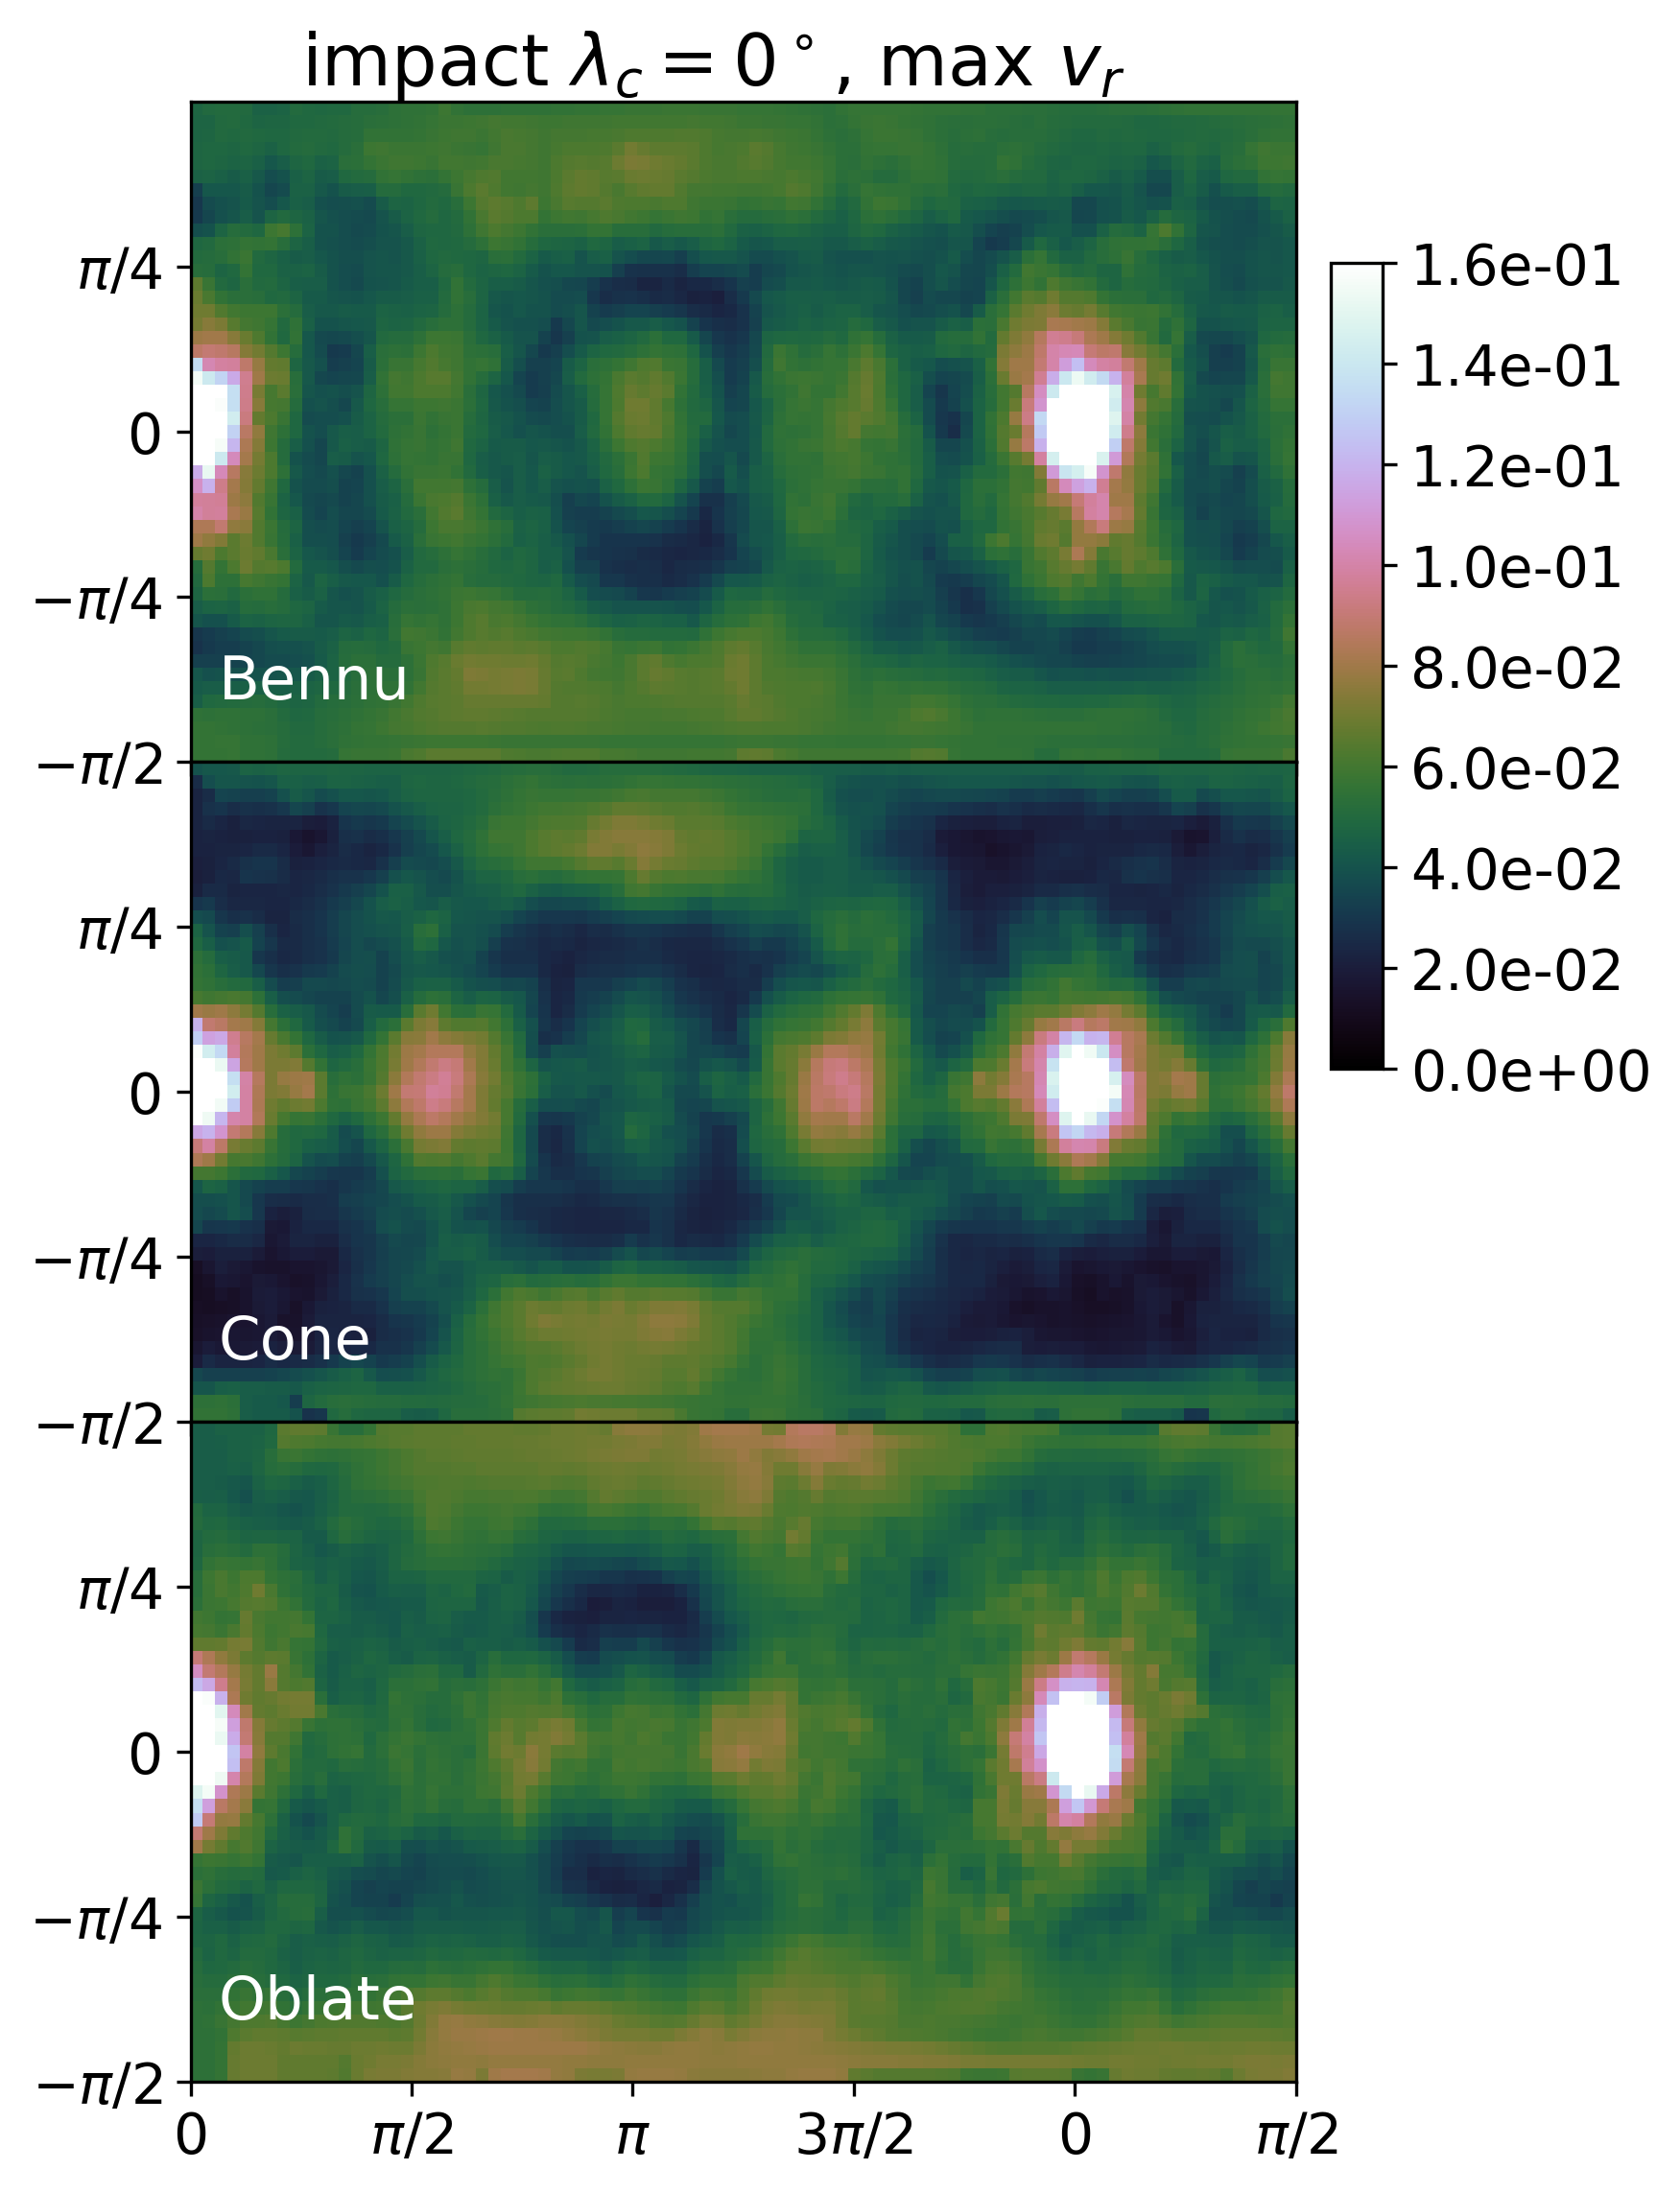

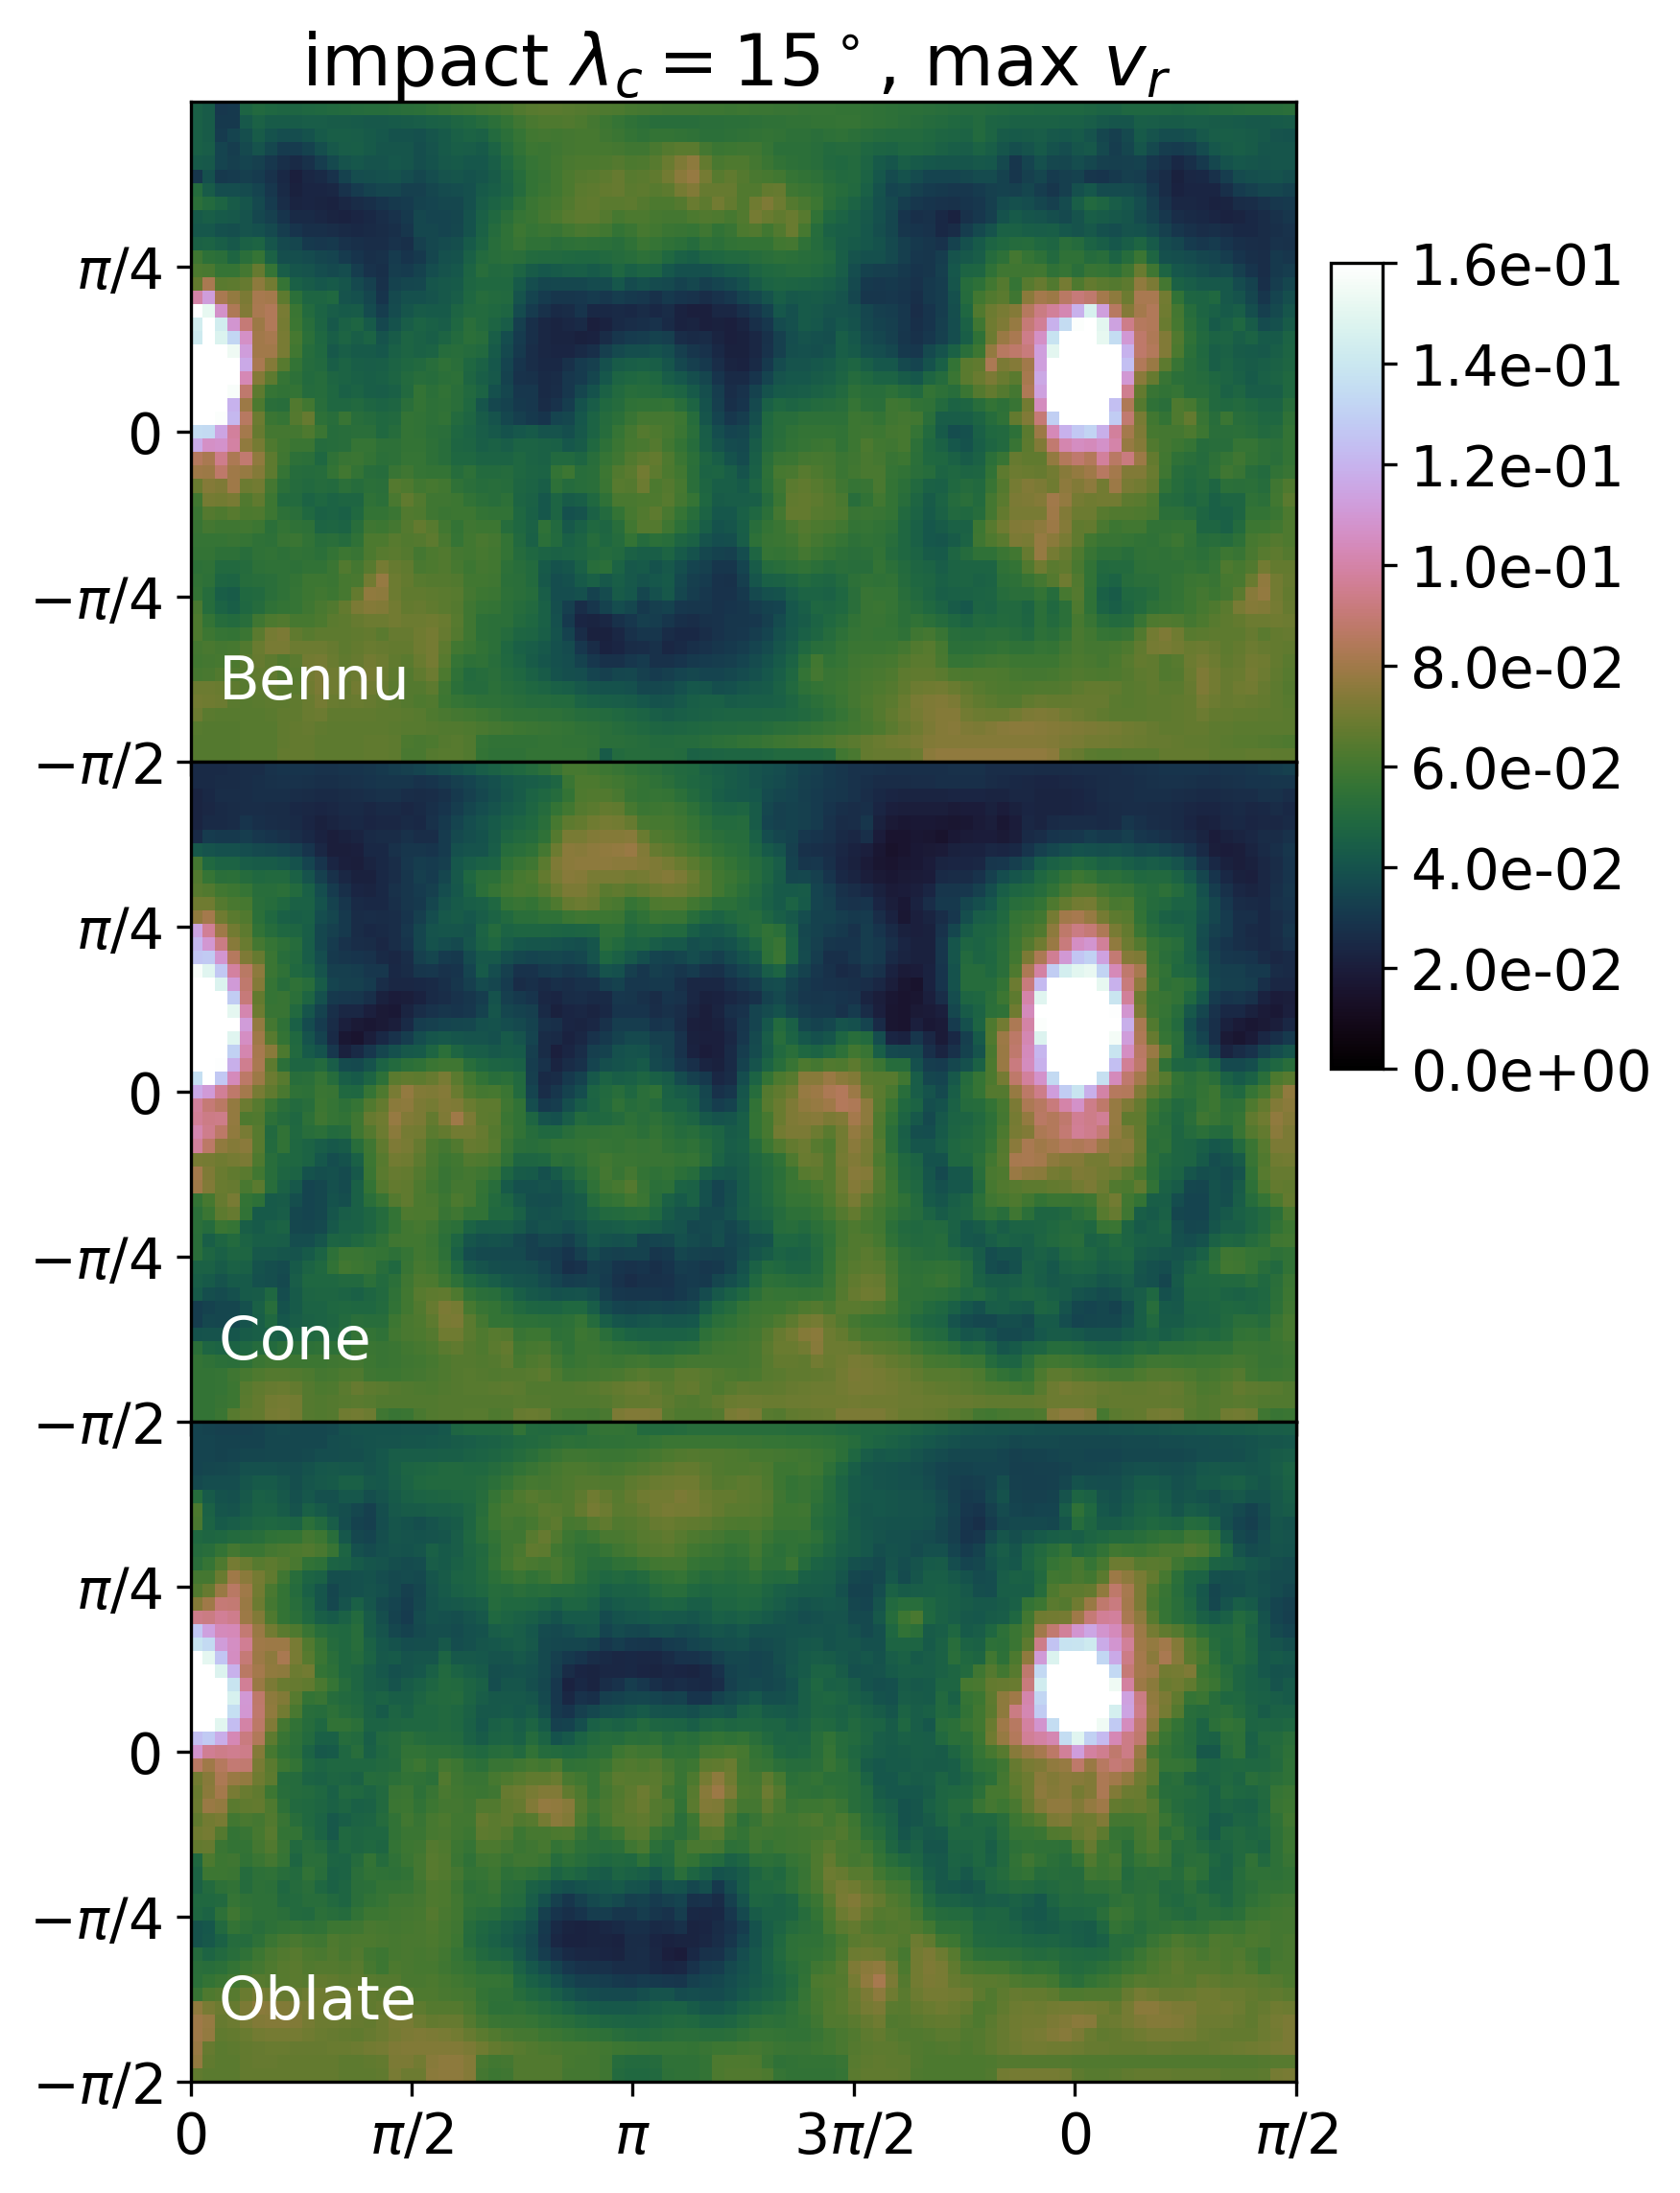

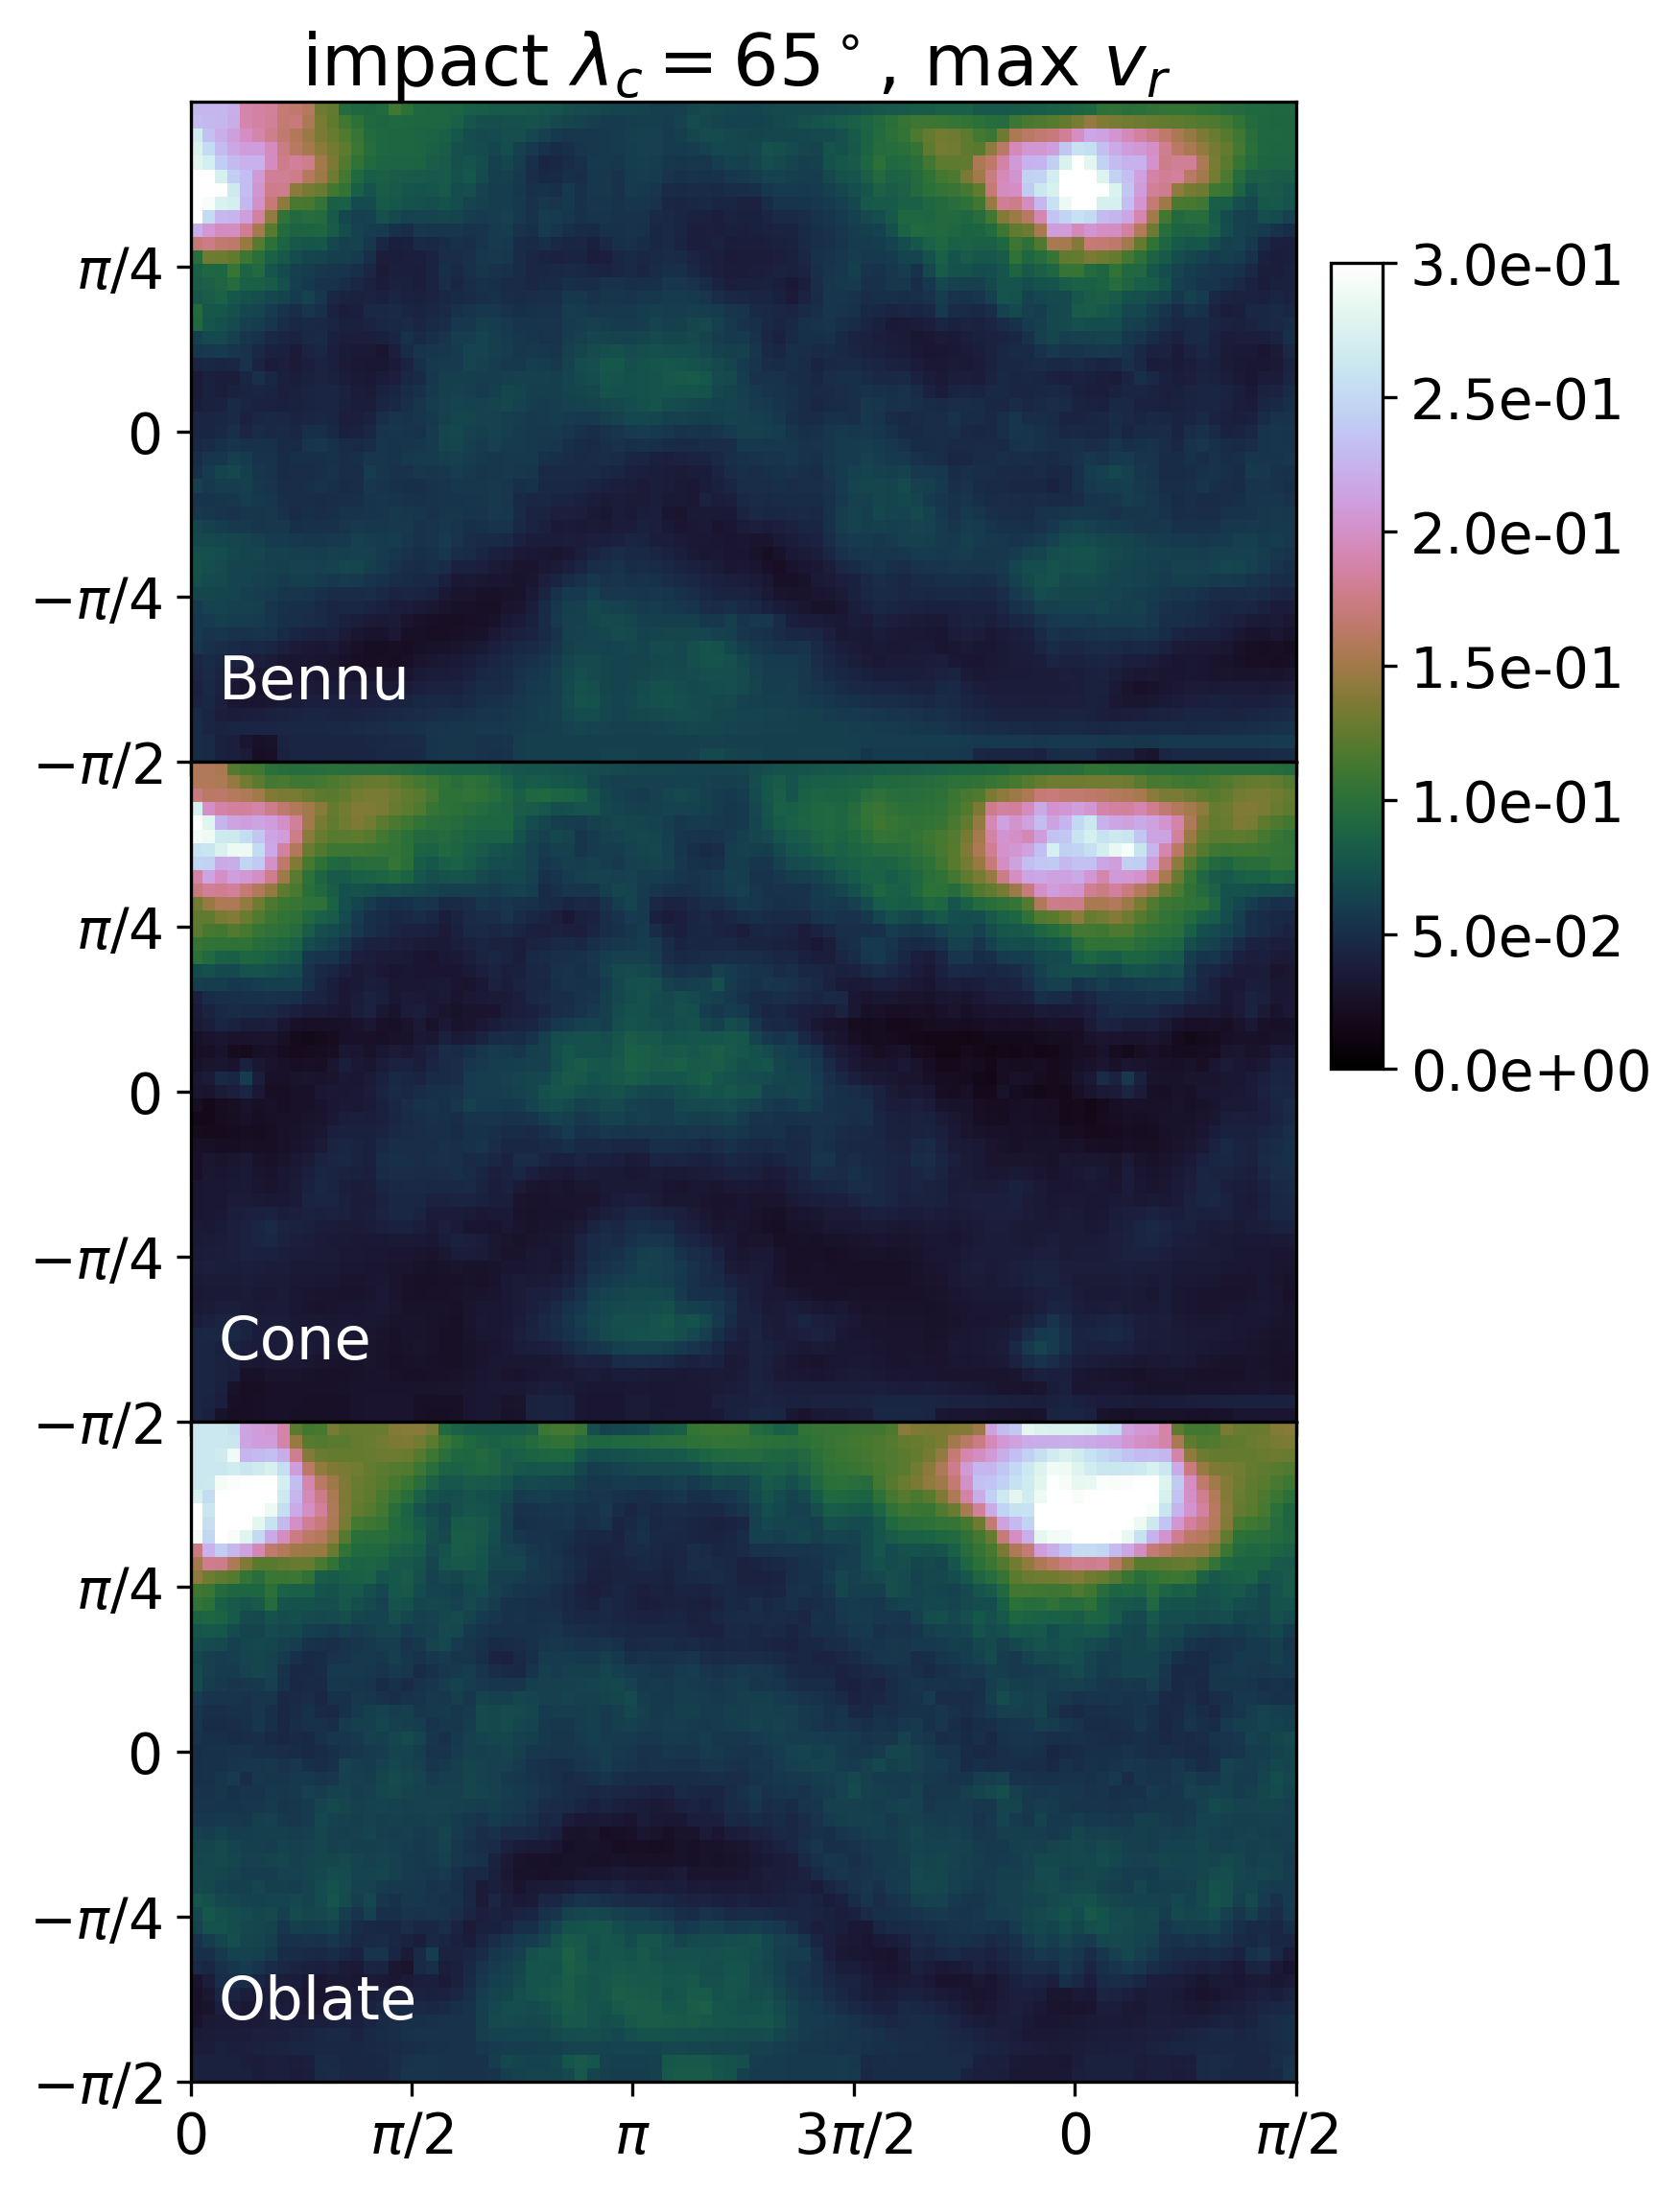

In [45]:
# equatorial impacts, images of max vr 
zmin=0; zmax=0.16
plt3_on_grid(lonarrb1,latarrb1,maxb1,
             lonarrc1,latarrc1,maxc1,
             lonarro1,latarro1,maxo1,
             label_arr,zmin,zmax,0.5,toplabel_0+max_label,"max_eq_s.png")
# 15 degree impacts
plt3_on_grid(lonarrb2,latarrb2,maxb2,
             lonarrc2,latarrc2,maxc2,
             lonarro2,latarro2,maxo2,
             label_arr,zmin,zmax,0.5,toplabel_15+max_label,"max_15_s.png")
# 65 degree impacts
plt3_on_grid(lonarrb3,latarrb3,maxb3,
             lonarrc3,latarrc3,maxc3,
             lonarro3,latarro3,maxo3,
             label_arr,zmin,0.3,0.5,toplabel_65+max_label,"max_65_s.png")